# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load ABM B lineage

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/adult_bm/data/abm_raw_dr_20200717.h5ad')

In [5]:
adata.raw = adata

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD14 monocyte             3670
CD16 monocyte             1938
CD56 bright NK            1228
CLP                        882
CMP                        288
DC1                        135
DC2                        481
DC3                        550
DC precursor               462
HSC                        497
LMPP                        80
MEMP                       785
MK                         577
MOP                       1440
MPP                        365
Treg                      6327
early MK                   136
early erythroid           5441
erythroid macrophage        77
immature B cell           2728
late erythroid            1150
mature CD8 T cell        15725
mature NK                 6074
memory B cell             4106
memory CD4 T cell        22197
mid erythroid             2192
monocyte-DC                515
myelocyte                 6675
myeloid DC progenitor      110
naive B cell             19265
naive CD4 T cell          5873
naive CD8 T cell          8

In [7]:
adata = adata[adata.obs['cell.labels'].isin(['HSC', 'LMPP', 'pro B progenitor', 'pre B cell', 'immature B cell', 
                    'naive B cell'])].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC                   497
LMPP                   80
immature B cell      2728
naive B cell        19265
pre B cell            971
pro B progenitor     1390
dtype: int64

# Change the colours for the B lineage

In [9]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['HSC', 'LMPP', 'immature B cell', 'naive B cell', 'pre B cell', 'pro B progenitor'], dtype='object')

In [10]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(['HSC', 'LMPP', 'pro B progenitor', 
                    'pre B cell', 'immature B cell', 'naive B cell'])

In [11]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['HSC', 'LMPP', 'pro B progenitor', 'pre B cell', 'immature B cell', 'naive B cell'], dtype='object')

In [12]:
adata.obs["cell.labels"].cat.categories[2]

'pro B progenitor'

In [13]:
new_colors = np.empty(len(adata.obs["cell.labels"].cat.categories), dtype=object) 


new_colors[[0]] = '#b63262' # HSC
new_colors[[1]] = '#1B6633' # LMPP
new_colors[[2]] = '#C8D895' # Pro B
new_colors[[3]] = '#4C79BC' # Pre B
new_colors[[4]] = '#A9479A' # Immature B
new_colors[[5]] = '#F3C3DB' # naive B

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#b63262', '#1B6633', '#C8D895', '#4C79BC', '#A9479A', '#F3C3DB'],
      dtype=object)

# Save B cells for cluster monocle run

In [14]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs3e_abm_bcell_raw_20200717.h5ad")

# Pre-process the B cell dataset

In [15]:
adata=sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs3e_abm_bcell_raw_20200717.h5ad")

In [16]:
# normalise count data 
sc.pp.normalize_total(adata)

In [17]:
# log the count data 
sc.pp.log1p(adata)

In [18]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [19]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [20]:
# run pca
sc.tl.pca(adata, n_comps=50)

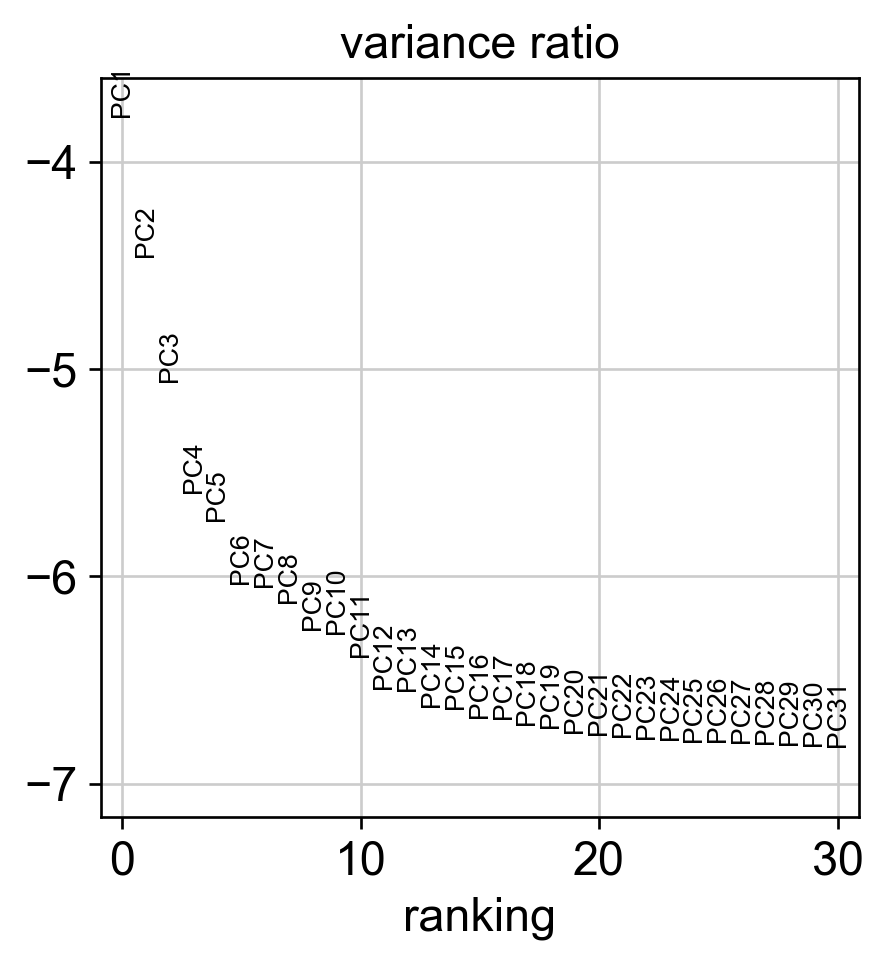

In [21]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=30) 

In [23]:
# run umap
sc.tl.umap(adata) 

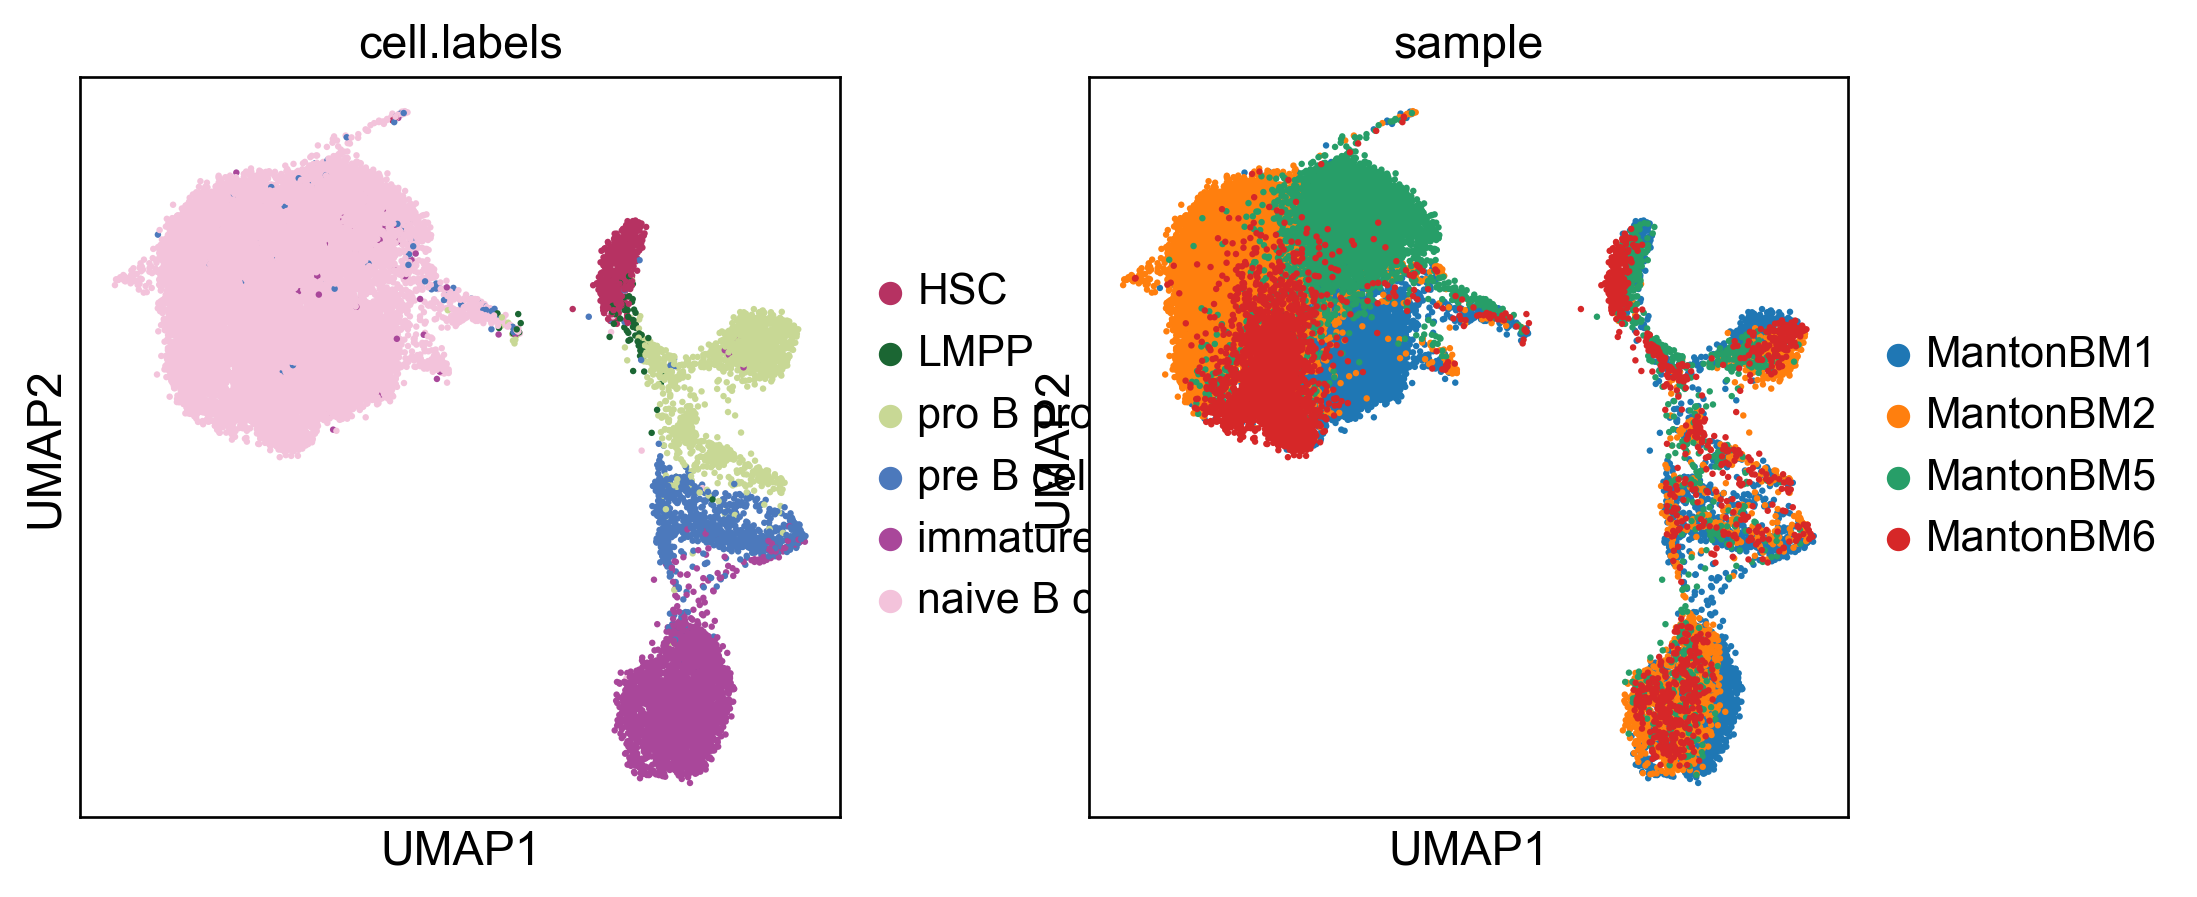

In [24]:
sc.pl.umap(adata, color=['cell.labels', 'sample'], size=15) 

# Run harmony batch correction

In [25]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['sample']

In [26]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [27]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

R[write to console]: Harmony 7/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

In [28]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add UMAP and FDG

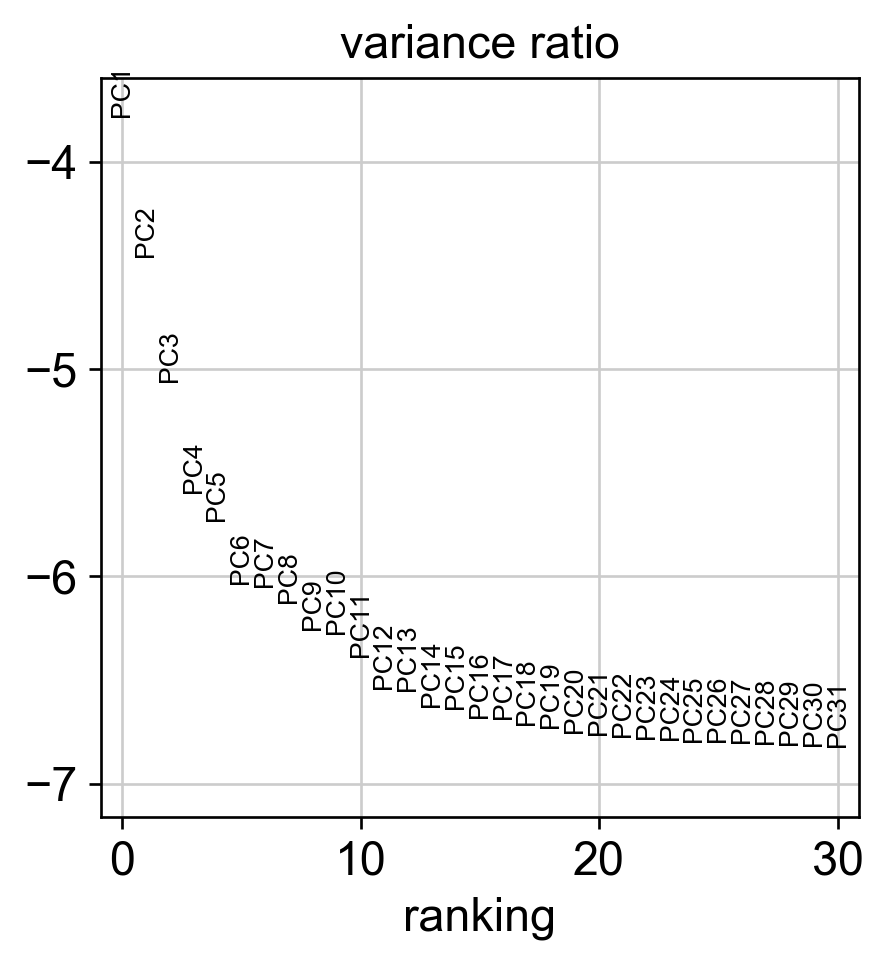

In [29]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [30]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=15) 

In [31]:
# run umap
sc.tl.umap(adata) 

In [32]:
# run fdg 
sc.tl.draw_graph(adata, init_pos='X_pca', layout='fa')

# Plot UMAP and FDG 

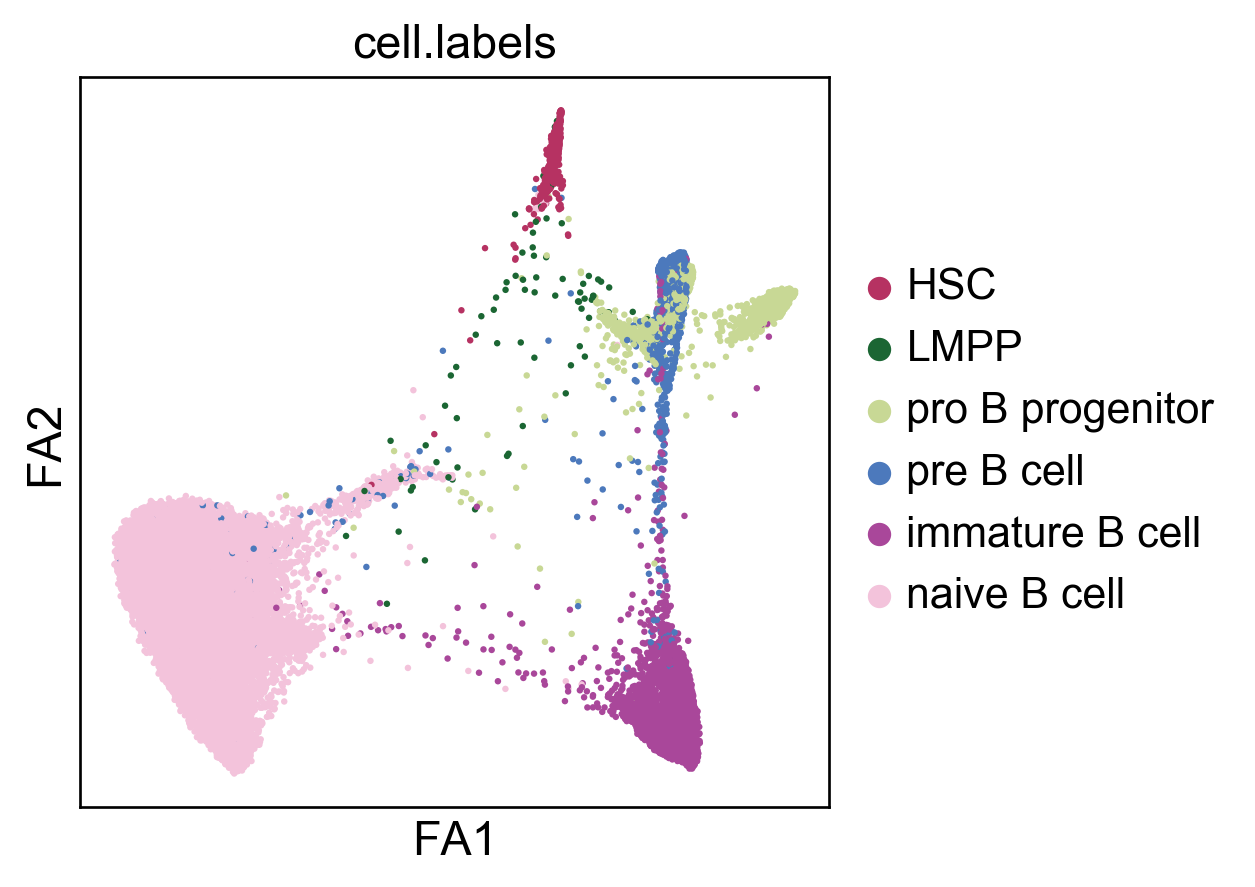

In [33]:
sc.pl.draw_graph(adata, color=['cell.labels'], layout='fa', save="abm_bcell_fdg_celltype_20200717.pdf", size=15)

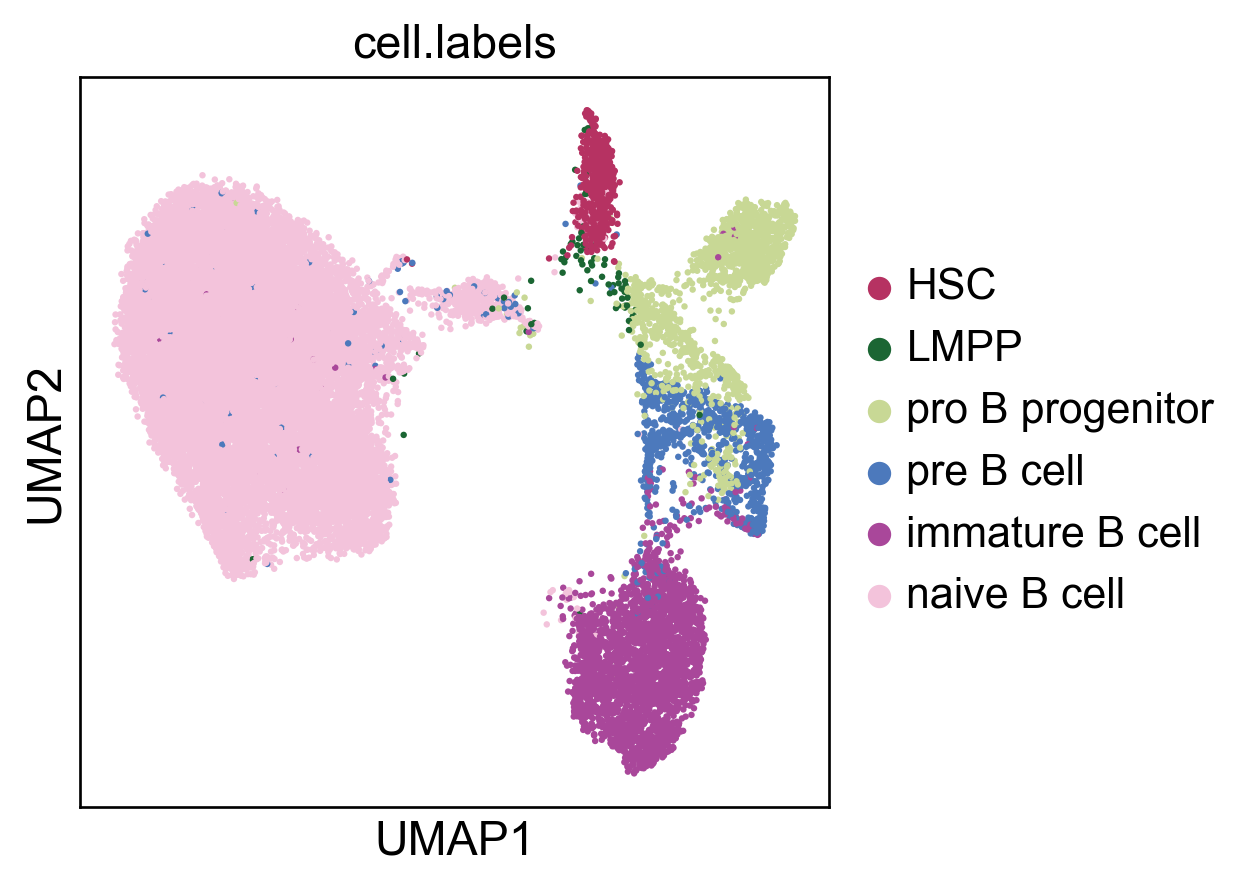

In [34]:
sc.pl.umap(adata, color=['cell.labels'], save="abm_bcell_umap_celltype_20200717.pdf", size=15)

# Save the data

In [35]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/figs3e_abm_bcell_dr_20200717.h5ad")